<a href="https://colab.research.google.com/github/gsgh3016/Pytorch-study/blob/main/Gamchan/chap13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 13-01 RNN을 이용한 텍스트 분류(Text classification using PyTorch)

## 1. 훈련 데이터에 대한 이해

정상 vs 스팸 메일 지도 학습

![](https://wikidocs.net/images/page/24873/%EB%B6%84%EB%A5%98.png)

## 2. 훈련 데이터와 테스트 데이터

9:1 train:test

## 3. 단어에 대한 인덱스 부여
빈도수 &rarr; 이미 처리된 데이터

## 4. RNN으로 분류하기

```python
nn.RNN(input_size, hidden_size, batch_first=True)
```

- hidden_size = 출력의 크기(output_dim).
- timesteps = 시점의 수 = 각 문서에서의 단어 수.
- input_size = 입력의 크기 = 각 단어의 벡터 표현의 차원 수.

## 5. RNN의 다-대-일(Many-to-One) 문제

텍스트 분류는 모든 시점(time step)에 대해서 입력을 받지만 최종 시점의 RNN 셀만이 은닉 상태를 출력 &rarr; 활성화 함수를 통해 정답

# 13-02 LSTM을 이용한 네이버 영화 리뷰 분류

## 1. 네이버 영화 리뷰 데이터에 대한 이해와 전처리

In [ ]:
!pip install konlpy

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

### 1) 데이터 로드하기

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7e0d33b43c10>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [ ]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [ ]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 2) 데이터 정제하기

In [ ]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [ ]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [ ]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<Axes: >

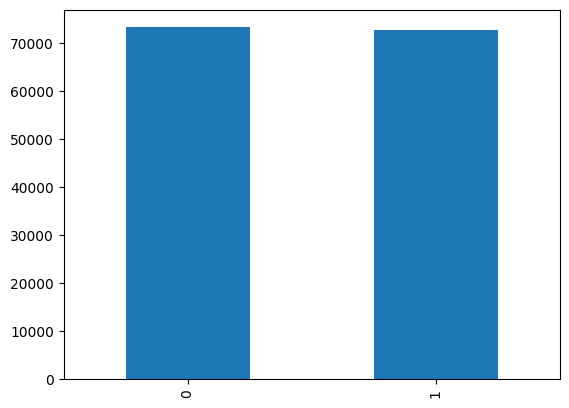

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [ ]:
print(train_data.isnull().values.any())

True


In [ ]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [ ]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [ ]:
print(len(train_data))

146182


In [ ]:
#알파벳과 공백을 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))

do you expect people to read the FAQ etc and actually accept hard atheism


In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

<ipython-input-20-4419b0600db1>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [ ]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

<ipython-input-21-c2f9538d5bc3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


id            0
document    789
label         0
dtype: int64


In [ ]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [ ]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [ ]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

<ipython-input-24-c182d8fa0991>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


전처리 후 테스트용 샘플의 개수 : 48852


<ipython-input-24-c182d8fa0991>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [ ]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
!sudo apt-get install g++ openjdk-8-jdk python3-dev python3-pip curl
!python3 -m pip install konlpy
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
g++ is already the newest version (4:11.2.0-1ubuntu1).
curl is already the newest version (7.81.0-1ubuntu1.14).
python3-dev is already the newest version (3.10.6-1~22.04).
openjdk-8-jdk is already the newest version (8u382-ga-1~22.04.1).
python3-pip is already the newest version (22.0.2+dfsg-1ubuntu0.4).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
curl is already the newest version (7.81.0-1ubuntu1.14).
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [ ]:
mecab = Mecab()
mecab.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['와',
 '이런',
 '것',
 '도',
 '영화',
 '라고',
 '차라리',
 '뮤직',
 '비디오',
 '를',
 '만드',
 '는',
 '게',
 '나을',
 '뻔']

In [ ]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [00:25<00:00, 5763.35it/s]


In [ ]:
print(X_train[:3])

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다']]


In [ ]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [00:07<00:00, 6329.43it/s]


### 4) 학습 데이터, 검증 데이터, 테스트 데이터

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [ ]:
print('--------학습 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_train==0)/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_train)/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_valid==0)/len(y_valid) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_valid)/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_test==0)/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_test)/len(y_test) * 100,3)}%')

--------학습 데이터의 비율-----------
부정 리뷰 = 50.238%
긍정 리뷰 = 49.762%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.239%
긍정 리뷰 = 49.761%
--------테스트 데이터의 비율-----------
부정 리뷰 = 49.808%
긍정 리뷰 = 50.192%


### 5) 단어 집합 만들기

In [ ]:
word_list = []
for sent in X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 45296


In [ ]:
print('훈련 데이터에서의 단어 영화의 등장 횟수 :', word_counts['영화'])
print('훈련 데이터에서의 단어 공감의 등장 횟수 :', word_counts['공감'])

훈련 데이터에서의 단어 영화의 등장 횟수 : 45791
훈련 데이터에서의 단어 공감의 등장 횟수 : 756


In [ ]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['영화', '보', '있', '없', '좋', '나', '었', '만', '는데', '너무']


In [ ]:
threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45296
등장 빈도가 2번 이하인 희귀 단어의 수: 26104
단어 집합에서 희귀 단어의 비율: 57.62981278700106
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.2768285068857192


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))

단어 집합의 크기 : 19192


In [ ]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

In [ ]:
for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

In [ ]:
vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 19194


In [ ]:
print('단어 <PAD>와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word_to_index['<UNK>'])
print('단어 영화와 맵핑되는 정수 :', word_to_index['영화'])

단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1
단어 영화와 맵핑되는 정수 : 2


### 6) 정수 인코딩

In [ ]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

In [ ]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

In [ ]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[924, 1866, 128, 7, 80, 48, 34]
[2415, 3138, 4, 2095, 422, 87, 5768, 19, 307]


In [ ]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [ ]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']
복원된 첫번째 샘플 : ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']


### 7) 패딩

리뷰의 최대 길이 : 74
리뷰의 평균 길이 : 12.296705469676908


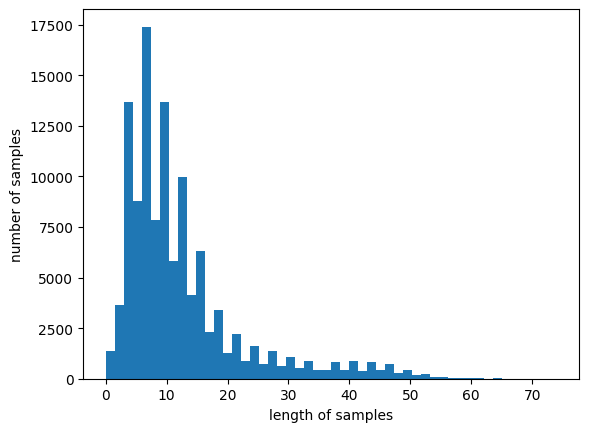

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 92.49703389101914


In [ ]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (116314, 30)
검증 데이터의 크기 : (29079, 30)
테스트 데이터의 크기 : (48852, 30)


In [ ]:
print('첫번째 샘플의 길이 :', len(padded_X_train[0]))
print('첫번째 샘플 :', padded_X_train[0])

첫번째 샘플의 길이 : 30
첫번째 샘플 : [ 924 1866  128    7   80   48   34    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


## 2. LSTM을 이용한 네이버 영화 리뷰 분류 모델

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cpu


In [ ]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))
print(train_label_tensor[:5])

tensor([0, 1, 1, 1, 1])


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # LSTM은 (hidden state, cell state)의 튜플을 반환합니다
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch_size, seq_length, hidden_dim), hidden: (1, batch_size, hidden_dim)

        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        return logits

In [ ]:
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

In [ ]:
total_batch = len(train_dataloader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 3635


In [ ]:
embedding_dim = 100
hidden_dim = 128
output_dim = 2
learning_rate = 0.01
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)

TextClassifier(
  (embedding): Embedding(19194, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 3. 평가 코드 작성

In [ ]:
def calculate_accuracy(logits, labels):
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

- `model.eval()`: 모델을 평가 모드로 설정합니다. 이렇게 하면 모델 내부의 모든 레이어에 대해 평가 모드가 활성화됩니다. 일부 레이어, 예를 들어 드롭아웃이나 배치 정규화는 학습과 평가 시 다르게 동작하기 때문에 이 설정이 중요합니다. 평가 모드가 설정되지 않으면, 이러한 레이어의 동작이 올바르지 않을 수 있으며, 이로 인해 평가 결과가 제대로 나오지 않을 수 있습니다.

- `with torch.no_grad()`: 이 문장은 자동 미분 엔진에서 그래디언트 계산을 비활성화합니다. 평가 중에는 기울기를 계산할 필요가 없으므로, 이렇게 설정하면 메모리를 절약하고 속도를 높일 수 있습니다. 만약 이 설정이 적용되지 않으면, 평가 과정에서 그래디언트가 계산되고 메모리를 차지하게 됩니다. 그러나 평가 결과 자체에는 직접적인 영향을 주지 않습니다.

In [ ]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

## 4. 학습

In [ ]:
num_epochs = 5

# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch 1/5:
Train Loss: 0.4990, Train Accuracy: 0.7234
Validation Loss: 0.3672, Validation Accuracy: 0.8346
Validation loss improved from inf to 0.3672. 체크포인트를 저장합니다.
Epoch 2/5:
Train Loss: 0.3258, Train Accuracy: 0.8586
Validation Loss: 0.3454, Validation Accuracy: 0.8466
Validation loss improved from 0.3672 to 0.3454. 체크포인트를 저장합니다.
Epoch 3/5:
Train Loss: 0.2644, Train Accuracy: 0.8892
Validation Loss: 0.3422, Validation Accuracy: 0.8524
Validation loss improved from 0.3454 to 0.3422. 체크포인트를 저장합니다.
Epoch 4/5:
Train Loss: 0.2072, Train Accuracy: 0.9160
Validation Loss: 0.3717, Validation Accuracy: 0.8531
Epoch 5/5:
Train Loss: 0.1561, Train Accuracy: 0.9398
Validation Loss: 0.4228, Validation Accuracy: 0.8510


## 5. 모델 로드 및 평가

In [ ]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

TextClassifier(
  (embedding): Embedding(19194, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.3422
Best model validation accuracy: 0.8524


In [ ]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model test loss: 0.3480
Best model test accuracy: 0.8501


## 6. 모델 테스트

In [ ]:
index_to_tag = {0 : '부정', 1 : '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input text
    tokens = mecab.morphs(text) # 토큰화
    tokens = [word for word in tokens if not word in stopwords] # 불용어 제거
    token_indices = [word_to_index.get(token, 1) for token in tokens]

    # Convert tokens to tensor
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # Pass the input tensor through the model
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # Get the predicted class index
    predicted_index = torch.argmax(logits, dim=1)

    # Convert the predicted index to its corresponding tag
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag

In [ ]:
test_input = "이 영화 개꿀잼 ㅋㅋㅋ"
predict(test_input, model, word_to_index, index_to_tag)

'긍정'

In [ ]:
test_input = "이딴게 영화냐 ㅉㅉ"
predict(test_input, model, word_to_index, index_to_tag)

'부정'

In [ ]:
test_input = "감독 뭐하는 놈이냐?"
predict(test_input, model, word_to_index, index_to_tag)

'부정'

In [ ]:
test_input = "와 개쩐다 정말 세계관 최강자들의 영화다"
predict(test_input, model, word_to_index, index_to_tag)

'부정'

In [ ]:
test_input = "감독 참 잘 한다"
predict(test_input, model, word_to_index, index_to_tag)

'부정'

# 13-03 GRU를 이용한 IMDB 리뷰 분류하기

## 1. 데이터 로드 및 단어 토큰화

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import torch
import urllib.request
from tqdm import tqdm
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

In [ ]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/pytorch-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/IMDB%20Dataset.csv", filename="IMDB Dataset.csv")

('IMDB Dataset.csv', <http.client.HTTPMessage at 0x7e0d33d07700>)

In [ ]:
df = pd.read_csv('IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
print('결측값 여부 :',df.isnull().values.any())

결측값 여부 : False


<Axes: >

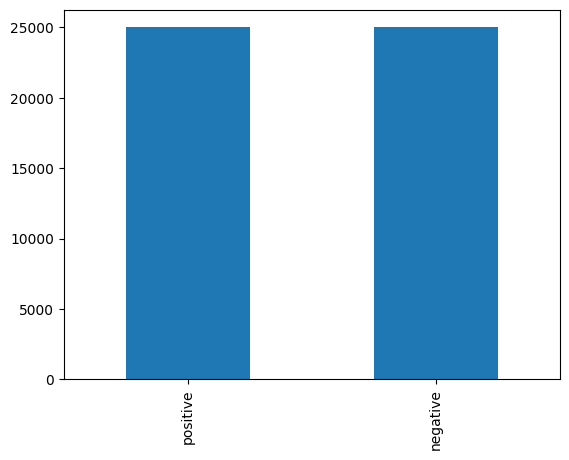

In [ ]:
df['sentiment'].value_counts().plot(kind='bar')

In [ ]:
print('레이블 개수')
print(df.groupby('sentiment').size().reset_index(name='count'))

레이블 개수
  sentiment  count
0  negative  25000
1  positive  25000


In [ ]:
df['sentiment'] = df['sentiment'].replace(['positive','negative'],[1, 0])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
X_data = df['review']
y_data = df['sentiment']
print('영화 리뷰의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

영화 리뷰의 개수: 50000
레이블의 개수: 50000


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=0, stratify=y_data)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, random_state=0, stratify=y_train)

print('--------훈련 데이터의 비율-----------')
print(f'부정 리뷰 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(y_valid.value_counts()[0]/len(y_valid) * 100,3)}%')
print(f'긍정 리뷰 = {round(y_valid.value_counts()[1]/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')

--------훈련 데이터의 비율-----------
부정 리뷰 = 50.0%
긍정 리뷰 = 50.0%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.0%
긍정 리뷰 = 50.0%
--------테스트 데이터의 비율-----------
부정 리뷰 = 50.0%
긍정 리뷰 = 50.0%


In [ ]:
def tokenize(sentences):
  tokenized_sentences = []
  for sent in tqdm(sentences):
    tokenized_sent = word_tokenize(sent)
    tokenized_sent = [word.lower() for word in tokenized_sent]
    tokenized_sentences.append(tokenized_sent)
  return tokenized_sentences

tokenized_X_train = tokenize(X_train)
tokenized_X_valid = tokenize(X_valid)
tokenized_X_test = tokenize(X_test)

100%|██████████| 25000/25000 [00:59<00:00, 417.81it/s]


In [ ]:
# 상위 샘플 2개 출력
for sent in tokenized_X_train[:2]:
  print(sent)

['have', 'you', 'ever', ',', 'or', 'do', 'you', 'have', ',', 'a', 'pet', 'who', "'s", 'been', 'with', 'you', 'through', 'thick', 'and', 'thin', ',', 'who', 'you', "'d", 'be', 'lost', 'without', ',', 'and', 'who', 'you', 'love', 'no', 'matter', 'what', '?', 'betcha', 'never', 'thought', 'they', 'feel', 'the', 'same', 'way', 'about', 'you', '!', '<', 'br', '/', '>', '<', 'br', '/', '>', 'wonderful', ',', 'wonderful', 'family', 'film', '.', 'if', 'you', 'have', 'a', 'soft', 'spot', 'for', 'animals', ',', 'this', 'is', 'guaranteed', 'to', 'make', 'you', 'cry', 'no', 'matter', 'your', 'age', '.', 'i', 'used', 'to', 'watch', 'this', 'movie', 'all', 'the', 'time', 'when', 'i', 'was', 'a', 'little', 'kid', ',', 'and', 'i', 'find', 'that', 'now', ',', 'at', 'age', 'sixteen', ',', 'i', 'love', 'it', 'as', 'much', 'as', 'i', 'did', 'then', '.', 'i', 'could', 'never', 'decide', 'on', 'a', 'favorite', 'character', 'then', ',', 'and', 'i', 'still', 'do', "n't", 'think', 'i', 'can', '!', 'i', 'love',

## 2. Vocab 만들기

In [ ]:
word_list = []
for sent in tokenized_X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 100586


In [ ]:
print('훈련 데이터에서의 단어 the의 등장 횟수 :', word_counts['the'])
print('훈련 데이터에서의 단어 love의 등장 횟수 :', word_counts['love'])

훈련 데이터에서의 단어 the의 등장 횟수 : 265697
훈련 데이터에서의 단어 love의 등장 횟수 : 4984


In [ ]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['the', ',', '.', 'a', 'and', 'of', 'to', 'is', '/', '>']


In [ ]:
threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 100586
등장 빈도가 2번 이하인 희귀 단어의 수: 61877
단어 집합에서 희귀 단어의 비율: 61.51651323245779
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.3294254426463437


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))

단어 집합의 크기 : 38709


In [ ]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 38711


## 3. 정수 인코딩

In [ ]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

encoded_X_train = texts_to_sequences(tokenized_X_train, word_to_index)
encoded_X_valid = texts_to_sequences(tokenized_X_valid, word_to_index)
encoded_X_test = texts_to_sequences(tokenized_X_test, word_to_index)

In [ ]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[38, 29, 140, 3, 52, 54, 29, 38, 3, 5, 3406, 47, 19, 95, 22, 29, 161, 4059, 6, 1741, 3, 47, 29, 293, 39, 469, 218, 3, 6, 47, 29, 134, 71, 532, 61, 59, 25184, 130, 214, 44, 249, 2, 189, 114, 58, 29, 41, 12, 13, 10, 11, 12, 13, 10, 11, 384, 3, 384, 253, 26, 4, 57, 29, 38, 5, 2280, 1587, 23, 1477, 3, 17, 9, 5775, 8, 111, 29, 1440, 71, 532, 141, 677, 4, 16, 343, 8, 126, 17, 24, 43, 2, 75, 63, 16, 20, 5, 137, 538, 3, 6, 16, 172, 18, 164, 3, 42, 677, 12075, 3, 16, 134, 14, 21, 89, 21, 16, 83, 110, 4, 16, 94, 130, 1124, 30, 5, 494, 121, 110, 3, 6, 16, 145, 54, 31, 120, 16, 73, 41, 16, 134, 43, 301, 7, 2, 1477, 4, 2, 425, 204, 66, 168, 6, 3964, 3, 50, 5, 1961, 3, 25, 19699, 253, 4, 16, 54, 134, 580, 3, 6, 105, 42, 2, 152, 36, 544, 18, 36, 55, 5, 253, 42, 247, 4, 933, 3, 421, 3, 25, 40, 227, 407, 18, 17, 9, 965, 8, 39, 5, 253, 26, 3, 6, 14, 17326, 18, 233, 872, 4, 8000, 55, 53, 2, 416, 4967, 7, 33, 1, 32, 6, 2669, 9, 2, 416, 1, 2144, 8, 2, 208, 3, 8988, 13008, 12, 13, 10, 11, 12, 13, 10, 11, 2,

In [ ]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', tokenized_X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['have', 'you', 'ever', ',', 'or', 'do', 'you', 'have', ',', 'a', 'pet', 'who', "'s", 'been', 'with', 'you', 'through', 'thick', 'and', 'thin', ',', 'who', 'you', "'d", 'be', 'lost', 'without', ',', 'and', 'who', 'you', 'love', 'no', 'matter', 'what', '?', 'betcha', 'never', 'thought', 'they', 'feel', 'the', 'same', 'way', 'about', 'you', '!', '<', 'br', '/', '>', '<', 'br', '/', '>', 'wonderful', ',', 'wonderful', 'family', 'film', '.', 'if', 'you', 'have', 'a', 'soft', 'spot', 'for', 'animals', ',', 'this', 'is', 'guaranteed', 'to', 'make', 'you', 'cry', 'no', 'matter', 'your', 'age', '.', 'i', 'used', 'to', 'watch', 'this', 'movie', 'all', 'the', 'time', 'when', 'i', 'was', 'a', 'little', 'kid', ',', 'and', 'i', 'find', 'that', 'now', ',', 'at', 'age', 'sixteen', ',', 'i', 'love', 'it', 'as', 'much', 'as', 'i', 'did', 'then', '.', 'i', 'could', 'never', 'decide', 'on', 'a', 'favorite', 'character', 'then', ',', 'and', 'i', 'still', 'do', "n't", 'think', 'i', 'can', '!',

## 4. 패딩

리뷰의 최대 길이 : 2818
리뷰의 평균 길이 : 279.1958


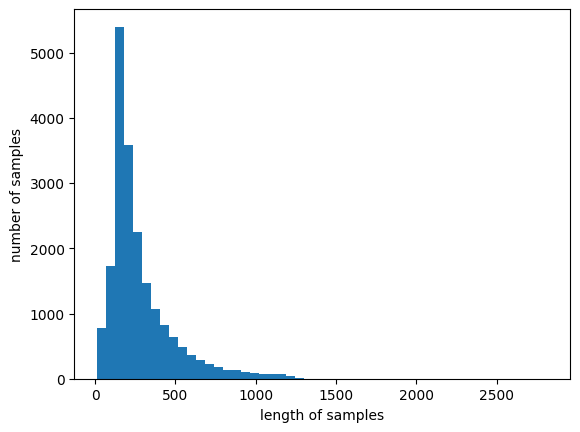

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 500
below_threshold_len(max_len, encoded_X_train)

전체 샘플 중 길이가 500 이하인 샘플의 비율: 87.795


In [ ]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (20000, 500)
검증 데이터의 크기 : (5000, 500)
테스트 데이터의 크기 : (25000, 500)


## 5. 모델링

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cpu


In [ ]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))
print(train_label_tensor[:5])

tensor([1, 1, 0, 0, 0])


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim) # output_dim = 분류하고자하는 카테고리의 개수

    def forward(self, x):
        # x: (batch_size, seq_length) == (32, 500)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim) == (32, 500, 100) == (데이터의 개수, 문장길이, 단어 벡터의 차원)
        gru_out, hidden = self.gru(embedded)  # gru_out: (batch_size, seq_length, hidden_dim), hidden: (1, batch_size, hidden_dim)
        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        return logits

In [ ]:
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

In [ ]:
total_batch = len(train_dataloader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 625


In [ ]:
embedding_dim = 100
hidden_dim = 128
output_dim = 2
learning_rate = 0.01
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)

TextClassifier(
  (embedding): Embedding(38711, 100)
  (gru): GRU(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 6. 평가 코드 작성

In [ ]:
def calculate_accuracy(logits, labels):
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [ ]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

## 7. 학습

In [ ]:
num_epochs = 5

# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch 1/5:
Train Loss: 0.6963, Train Accuracy: 0.5078
Validation Loss: 0.6924, Validation Accuracy: 0.5098
Validation loss improved from inf to 0.6924. 체크포인트를 저장합니다.
Epoch 2/5:
Train Loss: 0.6900, Train Accuracy: 0.5209
Validation Loss: 0.6920, Validation Accuracy: 0.5118
Validation loss improved from 0.6924 to 0.6920. 체크포인트를 저장합니다.
Epoch 3/5:
Train Loss: 0.6235, Train Accuracy: 0.6332
Validation Loss: 0.5081, Validation Accuracy: 0.7664
Validation loss improved from 0.6920 to 0.5081. 체크포인트를 저장합니다.
Epoch 4/5:
Train Loss: 0.3276, Train Accuracy: 0.8632
Validation Loss: 0.3084, Validation Accuracy: 0.8704
Validation loss improved from 0.5081 to 0.3084. 체크포인트를 저장합니다.
Epoch 5/5:
Train Loss: 0.1750, Train Accuracy: 0.9368
Validation Loss: 0.3066, Validation Accuracy: 0.8788
Validation loss improved from 0.3084 to 0.3066. 체크포인트를 저장합니다.


## 8. 모델 로드 및 평가

In [ ]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

TextClassifier(
  (embedding): Embedding(38711, 100)
  (gru): GRU(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.3066
Best model validation accuracy: 0.8788


In [ ]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model test loss: 0.3186
Best model test accuracy: 0.8714


## 9. 모델 테스트

In [ ]:
index_to_tag = {0 : '부정', 1 : '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    # 모델 평가 모드
    model.eval()

    # 토큰화 및 정수 인코딩. OOV 문제 발생 시 <UNK> 토큰에 해당하는 인덱스 1 할당
    tokens = word_tokenize(text)
    token_indices = [word_to_index.get(token.lower(), 1) for token in tokens]

    # 리스트를 텐서로 변경
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # 모델의 예측
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # 레이블 인덱스 예측
    _, predicted_index = torch.max(logits, dim=1)  # (1,)

    # 인덱스와 매칭되는 카테고리 문자열로 변경
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag

In [ ]:
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

predict(test_input, model, word_to_index, index_to_tag)

'부정'

In [ ]:
test_input = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

predict(test_input, model, word_to_index, index_to_tag)

'긍정'

# 13-04 자연어 처리를 위한 1D CNN(1D Convolutional Neural Networks)

## 1. 2D 합성곱(2D Convolutions)

- 컨볼루션 연산: 커널/필터를 이동하며 커널 내 대응하는 원소들끼리 곱하고 이 결과를 합한 연산

## 2. 1D 합성곱(1D Convolutions)

![](https://wikidocs.net/images/page/80437/sentence_matrix.PNG)

- 임베딩 벡터 방향(&rarr;)이 아닌 단어 단위 방향(&darr;)

![](https://wikidocs.net/images/page/80437/%EB%84%A4%EB%B2%88%EC%A7%B8%EC%8A%A4%ED%85%9D.PNG)

- 커널 크기가 달라짐: n-gram이 달라짐!

## 3. 맥스 풀링(Max-pooling)

컨볼루션 + 활성화 함수 &rarr; 최대값으로 지정하는 연산

- 가장 중요하거나 두드러진 특징(ex: 특정 단어의 중요성을 강조)
- 문맥 상 중요한 신호 추출
- 차원 축소 & 오버피팅 줄이는데 도움 됨

# 13-05 1D CNN을 이용한 IMDB 리뷰 분류

In [ ]:
class CNN(torch.nn.Module):
  def __init__(self, vocab_size, num_labels):
    super(CNN, self).__init__()

    # 오직 하나의 종류의 필터만 사용함.
    self.num_filter_sizes = 1 # 윈도우 5짜리 1개만 사용
    self.num_filters = 256

    self.word_embed = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=128, padding_idx=0)
    # 윈도우 5짜리 1개만 사용
    self.conv1 = torch.nn.Conv1d(128, self.num_filters, 5, stride=1)
    self.dropout = torch.nn.Dropout(0.5)
    self.fc1 = torch.nn.Linear(1 * self.num_filters, num_labels, bias=True)

  def forward(self, inputs):
    # word_embed(inputs).shape == (배치 크기, 문장길이, 임베딩 벡터의 차원)
    # word_embed(inputs).permute(0, 2, 1).shape == (배치 크기, 임베딩 벡터의 차원, 문장 길이)
    embedded = self.word_embed(inputs).permute(0, 2, 1)

    # max를 이용한 maxpooling
    # conv1(embedded).shape == (배치 크기, 커널 개수, 컨볼루션 연산 결과) == ex) 32, 256, 496
    # conv1(embedded).permute(0, 2, 1).shape == (배치 크기, 컨볼루션 연산 결과, 커널 개수)
    # conv1(embedded).permute(0, 2, 1).max(1)[0]).shape == (배치 크기, 커널 개수)
    x = F.relu(self.conv1(embedded).permute(0, 2, 1).max(1)[0])

    # y_pred.shape == (배치 크기, 분류할 카테고리의 수)
    y_pred = self.fc1(self.dropout(x))

    return y_pred

In [ ]:
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

In [ ]:
model = CNN(vocab_size, num_labels = len(set(y_train)))
model.to(device)

CNN(
  (word_embed): Embedding(38711, 128, padding_idx=0)
  (conv1): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def calculate_accuracy(logits, labels):
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [ ]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

In [ ]:
num_epochs = 5

# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch 1/5:
Train Loss: 0.6616, Train Accuracy: 0.6384
Validation Loss: 0.5340, Validation Accuracy: 0.7098
Validation loss improved from inf to 0.5340. 체크포인트를 저장합니다.
Epoch 2/5:
Train Loss: 0.4937, Train Accuracy: 0.7602
Validation Loss: 0.3906, Validation Accuracy: 0.8308
Validation loss improved from 0.5340 to 0.3906. 체크포인트를 저장합니다.
Epoch 3/5:
Train Loss: 0.4069, Train Accuracy: 0.8131
Validation Loss: 0.3201, Validation Accuracy: 0.8638
Validation loss improved from 0.3906 to 0.3201. 체크포인트를 저장합니다.
Epoch 4/5:
Train Loss: 0.3126, Train Accuracy: 0.8691
Validation Loss: 0.3004, Validation Accuracy: 0.8724
Validation loss improved from 0.3201 to 0.3004. 체크포인트를 저장합니다.
Epoch 5/5:
Train Loss: 0.2347, Train Accuracy: 0.9045
Validation Loss: 0.3027, Validation Accuracy: 0.8738


In [ ]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

CNN(
  (word_embed): Embedding(38711, 128, padding_idx=0)
  (conv1): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.3004
Best model validation accuracy: 0.8724


In [ ]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model test loss: 0.3097
Best model test accuracy: 0.8675


In [ ]:
index_to_tag = {0 : '부정', 1 : '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    # 모델 평가 모드
    model.eval()

    # 토큰화 및 정수 인코딩. OOV 문제 발생 시 <UNK> 토큰에 해당하는 인덱스 1 할당
    tokens = word_tokenize(text)
    token_indices = [word_to_index.get(token.lower(), 1) for token in tokens]

    # 리스트를 텐서로 변경
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # 모델의 예측
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # 레이블 인덱스 예측
    _, predicted_index = torch.max(logits, dim=1)  # (1,)

    # 인덱스와 매칭되는 카테고리 문자열로 변경
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag

In [ ]:
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

predict(test_input, model, word_to_index, index_to_tag)

'부정'

In [ ]:
test_input = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

predict(test_input, model, word_to_index, index_to_tag)

'긍정'